In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr,gaussian_kde, chi2
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [3]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [4]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

def hessian(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    return np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])

In [5]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [6]:
corr1k = pd.read_csv("correlations1k09.csv")
corr1k

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.9,18.0,0.903419,1.089390,0.097283,0.053900,0.002399,0.980805,0.050014,0.000005,0.000005,-2.163635e-06,1.617252,1064.304065,809.793200,1.560022,52.182682,-0.867246,19.249601,2.000717
1,0.9,18.0,0.880510,0.900418,0.072240,0.056387,0.002568,0.986345,0.050987,0.000005,0.000208,9.437597e-07,1.065555,883.256873,633.153830,1.019300,55.154242,-0.456030,14.999991,1.458892
2,0.9,18.0,0.890377,0.961881,0.082584,0.053818,0.002419,0.973775,0.051611,-0.000006,0.000078,6.124129e-07,3.269298,938.554615,687.662628,1.081121,52.577734,-1.074140,16.910997,1.756507
3,0.9,18.0,0.887017,0.948254,0.079970,0.055989,0.002462,0.960862,0.050524,-0.000004,0.000226,2.409438e-06,2.523798,925.794610,679.780718,1.017131,54.798786,-0.288909,15.970099,1.622714
4,0.9,18.0,0.903981,1.029327,0.087613,0.051064,0.002302,1.071980,0.056499,-0.000003,0.000253,-2.940714e-06,3.714319,1003.176957,729.367019,1.033297,49.741617,1.941006,19.199965,1.964082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.9,18.0,0.889151,0.918919,0.073798,0.052875,0.002325,1.021505,0.054341,-0.000003,0.000280,-1.926490e-06,1.107616,902.675147,644.974565,1.168422,51.581353,-2.454938,16.413639,1.608448
496,0.9,18.0,0.899304,1.019476,0.092738,0.053381,0.002375,0.896689,0.045864,0.000003,-0.000001,1.237789e-06,1.998225,993.664762,758.629956,1.001167,52.022808,2.784617,18.134809,1.929712
497,0.9,18.0,0.885061,0.941046,0.080637,0.056500,0.002467,0.911010,0.048032,0.000005,0.000020,3.682346e-07,1.661396,918.733361,682.519932,1.129824,55.056610,2.190282,15.685870,1.589859
498,0.9,18.0,0.912444,1.208626,0.115978,0.053810,0.002462,0.978226,0.049456,0.000002,0.000062,-9.972236e-07,1.467780,1179.212634,920.703884,1.005056,52.508689,1.656873,21.507209,2.384821


In [7]:
rho = 0.9
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],jac=hessian,args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    h = hessian([A1,A2,D],a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    var = -np.linalg.inv(h)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.05263157894736841 1.0 18.000000000000004
1.0653055398429263 0.055952913372023835 0.052637410407484174 0.0023496521431247705 0.9750685639781351 0.04443262792192736 19.23856286994425 1.3760762059107654
0.8836279305484653 0.045741086791958936 0.05266866733821096 0.002352413716298115 0.9841489543652581 0.04527807202657584 15.777108197446186 1.1362671754036846
0.9435075702310931 0.049099786227259065 0.052627407079800105 0.0023486786866464904 0.9826324393092488 0.04501998776906854 16.928064911129514 1.210525484019286
0.9291266461793658 0.048393055685592254 0.052633327491972616 0.0023509987837869047 0.9603090228620813 0.0440184084732889 16.65281980929425 1.2002500514873184
1.0086912125283485 0.05251859606778836 0.05261032224643946 0.00235712225749053 1.0738469017844945 0.04946126835387162 18.172876527982382 1.3333301445993404
0.9179008321763509 0.04777894618651962 0.05262172310765444 0.0023499795587938765 0.9665685956754597 0.04434410186977915 16.443382275766478 1.1837749853661783
0.949

0.9918939334488872 0.05178090431091591 0.052632738366467605 0.0023580059058661983 1.0165365734544944 0.046727747560642845 17.845569587175884 1.3118775817123454
1.0591612674921675 0.05569926247322474 0.05262595851270927 0.002359172203954328 1.0286675788626187 0.04722639810277825 19.126213325622906 1.4131920821707902
1.1012561016148923 0.057880207690811585 0.05263685614196767 0.0023543981626655656 1.0311709275420335 0.047142660829195 19.92176817408467 1.4451819590682933
1.1639190312014704 0.06167526462622024 0.05265315778499948 0.0023575807958531913 0.9583641550356452 0.04364695514076675 21.10539842556343 1.5453993977223903
1.0034444628759347 0.052585530443336234 0.05263415889831592 0.0023540151615187906 0.9692954354546599 0.04435810234659293 18.064510270117395 1.3132087221003288
0.9858613982357495 0.051593980000572935 0.05262619086446146 0.002350961719220923 0.9528597010437981 0.04354839216017336 17.733284359774995 1.2782891671305903
1.175141413006419 0.06214612214044772 0.0526314214592

1.020390282665559 0.05315790643342812 0.05262569469953668 0.00235490513622649 1.062200104134843 0.04880196268273821 18.389583139784047 1.336822171600139
1.0055174212283642 0.05263178829575481 0.05263016845057967 0.002348355320070785 0.9599965706808111 0.0437978748202111 18.105343015813386 1.292241166157667
0.9777544437025627 0.05078187847232375 0.05258781426465046 0.002341775811760471 1.0223813378715554 0.04674003702585716 17.592794877953494 1.233147194284329
0.9909525090599488 0.05221476269317446 0.052651922602504585 0.0023607131300075273 0.9069059338918349 0.041515126049775496 17.820822869872 1.3235911957923407
0.9245770471422838 0.04795876761100828 0.052630615953075666 0.002348137056363248 0.9992880959796572 0.04585244692605544 16.567285322417984 1.1814339104082636
0.9973703632672495 0.05222321687299626 0.05262505327773729 0.0023601544981183835 0.9852129977998401 0.04525736619534867 17.952386765358032 1.3314569114748738
1.2051005727140989 0.0637118028141026 0.052650644564333986 0.00

0.9771250288811187 0.05078471759831013 0.05263356223143055 0.002350873804112139 1.0339437968225533 0.04744667715769919 17.564675987247178 1.2606097150503166
0.9516611489259698 0.0491505227235466 0.05263977968131035 0.002353799200119807 1.0997267270768065 0.050766751084942434 17.078744909030366 1.2336710476482944
0.9712116964072238 0.05058791895415662 0.05259844239247856 0.0023530654127021655 1.009530881243609 0.046362712544552535 17.464647473022975 1.2702722742117898
0.9490828430185033 0.04953661435045409 0.05261241095512818 0.0023448287275729817 0.9350699210012008 0.04266373365909593 17.039143726524003 1.2070155529037934
0.9474920303627526 0.04888546571163057 0.052667048378875196 0.0023513072182771155 1.1014446905542166 0.050782187478623286 16.990224619133823 1.2125924678983528
0.9818151571224869 0.050964860348519145 0.052673455366104766 0.0023515332071785073 1.0548732630948416 0.04842243814760804 17.63965730553311 1.2603564666172329
1.0797611391063187 0.057001542596713396 0.052629986

0.8415830230436621 0.04332551430460204 0.052629678736180324 0.002357874224012616 1.0251111936595432 0.047569273530608316 14.990654764630266 1.1043158808330482
1.0120712427328018 0.05285649343037681 0.05263710799435505 0.0023479570101030338 1.0019168927436328 0.045774019705743296 18.227333744120955 1.2961876048606014
1.1942514192199765 0.06321207671249349 0.05254063500674695 0.0023567773332698787 1.0147826047769362 0.046354502859950235 21.730053016424673 1.6092213202203114
1.047516860829769 0.05513573207639101 0.05263899050572091 0.002358259278040946 0.9545550230967853 0.043652349020429124 18.90001804301172 1.3913408885364098
1.032504072115827 0.05367721741452785 0.0526504961582868 0.0023517200148625386 1.1012986301401702 0.050570751277034656 18.610528816513696 1.3324531459226836
0.9995243219038895 0.052014375843625865 0.05263213560696903 0.0023551380810111545 1.0536366409307427 0.04843564992654251 17.99076125977192 1.3082544096332862
1.0346752952222291 0.054122274162488146 0.0526372768

1.0237715509674015 0.05359098277975786 0.0526278123283447 0.0023596694775271172 1.0215099502298721 0.04694042898373733 18.453051640833845 1.364088398929485
1.0616315639105864 0.05557112100507585 0.052644264879045916 0.0023441743783602564 0.9980239441391617 0.04540989525062483 19.166139015327943 1.3428564581931461
1.0146469187051923 0.053007531167944606 0.05263121447640066 0.0023539236037587083 1.0135559688389193 0.0464501914042054 18.278424957496476 1.3260246381685186
1.1551271191512231 0.06059915059166277 0.052637343381556075 0.0023539285761096165 1.091327597977871 0.04989358414709713 20.945011752929293 1.5121378281113818
0.9704643104362218 0.05045176471324916 0.05265995267127671 0.002354721723570534 1.036001554436208 0.04762236336816346 17.428886871475676 1.2621970706879384
0.8590539233153358 0.04422083633453612 0.0526371906757719 0.002351263965807148 1.0351826841419685 0.047861047490384924 15.320284427921518 1.1029615352112234
0.9383315123184685 0.04875429447745509 0.052619478303564

0.9321948270805037 0.04838969169550899 0.052640856265380544 0.0023521341432911637 1.009966688327014 0.04642378907442127 16.708580240051397 1.2051052639100064
0.8756972124603679 0.045091733718833814 0.05262492887968771 0.0023558924035016046 1.058489055333267 0.049056045720830145 15.640349566313075 1.1432322784877085
1.0979856301917919 0.05780698644033716 0.05261190513698848 0.0023562655880069623 0.9948338819107468 0.04547206649118764 19.86952805325918 1.4562165527245245
0.9863813733411239 0.05143280756052094 0.05263800676722737 0.002349799611620685 0.9963081850545005 0.04559105418786404 17.738957531257597 1.2694377725419634
0.9376051222266275 0.04867657872627069 0.052634779452357346 0.002351281068772859 1.0077957161161148 0.046289400101853166 16.813414095812938 1.2100680437007827
0.9339628766298568 0.04880873604187895 0.05262795968757506 0.002349400352246113 0.9180784377226043 0.04195633524335251 16.746515011684107 1.2032474434508262
1.0428125013595624 0.05472904756760004 0.052621302898

In [8]:
corr1k['A1'] = A1_list
corr1k['A2'] = A2_list
corr1k['dA1'] = dA1_list
corr1k['dA2'] = dA2_list
corr1k['D'] = D_list
corr1k['dD'] = dD_list
corr1k['dA1dA2'] = dA1dA2_list
corr1k['dA1dD'] = dA1dD_list
corr1k['dA2dD'] = dA2dD_list
corr1k['C'] = C_list
corr1k['dC'] = dC_list
corr1k['tau1'] = tau1_list
corr1k['tau2'] = tau2_list
corr1k['dtau1'] = dtau1_list
corr1k['dtau2'] = dtau2_list

In [9]:
corr1k

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,...,dD,dA1dA2,dA1dD,dA2dD,C,dC,tau1,tau2,dtau1,dtau2
0,0.9,18.0,0.903419,1.089390,0.097283,0.053900,0.002399,0.980805,0.050014,0.000005,...,0.044433,3.784740e-07,0.001805,4.140571e-07,19.238563,1.376076,1.092544,0.053983,0.335501,0.338577
1,0.9,18.0,0.880510,0.900418,0.072240,0.056387,0.002568,0.986345,0.050987,0.000005,...,0.045278,2.146107e-07,0.001482,2.967871e-07,15.777108,1.136267,0.897860,0.053517,0.289030,0.291397
2,0.9,18.0,0.890377,0.961881,0.082584,0.053818,0.002419,0.973775,0.051611,-0.000006,...,0.045020,3.676745e-07,0.001588,4.692722e-07,16.928065,1.210525,0.960184,0.053558,0.303740,0.306328
3,0.9,18.0,0.887017,0.948254,0.079970,0.055989,0.002462,0.960862,0.050524,-0.000004,...,0.044018,2.189565e-07,0.001533,2.768361e-07,16.652820,1.200250,0.967529,0.054809,0.309113,0.311703
4,0.9,18.0,0.903981,1.029327,0.087613,0.051064,0.002302,1.071980,0.056499,-0.000003,...,0.049461,-3.292748e-07,0.001867,-4.315329e-07,18.172877,1.333330,0.939325,0.048992,0.286127,0.288772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.9,18.0,0.889151,0.918919,0.073798,0.052875,0.002325,1.021505,0.054341,-0.000003,...,0.046727,5.712876e-07,0.001557,8.009278e-07,16.161085,1.141766,0.887838,0.051736,0.281665,0.284026
496,0.9,18.0,0.899304,1.019476,0.092738,0.053381,0.002375,0.896689,0.045864,0.000003,...,0.041027,-6.890611e-07,0.001569,-7.389684e-07,17.903099,1.343107,1.111362,0.058793,0.355597,0.358642
497,0.9,18.0,0.885061,0.941046,0.080637,0.056500,0.002467,0.911010,0.048032,0.000005,...,0.041895,-4.180210e-07,0.001459,-5.027628e-07,16.468044,1.224527,1.008524,0.057735,0.327585,0.330275
498,0.9,18.0,0.912444,1.208626,0.115978,0.053810,0.002462,0.978226,0.049456,0.000002,...,0.044451,-3.762904e-07,0.002033,-3.656833e-07,21.395339,1.572634,1.209116,0.053990,0.362559,0.366107


In [10]:
# display statistics
print(corr1k['A1'].mean(),corr1k['A1'].std(),corr1k['dA1'].mean(),corr1k['dA1'].std())
print(corr1k['a1'].mean(),corr1k['a1'].std(),corr1k['da1'].mean(),corr1k['da1'].std())
print(corr1k['A2'].mean(),corr1k['A2'].std(),corr1k['dA2'].mean(),corr1k['dA2'].std())
print(corr1k['a2'].mean(),corr1k['a2'].std(),corr1k['da2'].mean(),corr1k['da2'].std())

0.999301335936833 0.08504286996507442 0.052176807128277575 0.004760198000329227
1.0209274045469006 0.08868780392084383 0.08807930613538124 0.011735759637328553
0.05264852628451933 0.0001996682489316654 0.0023541921578278118 1.0345416826842678e-05
0.0535670252491606 0.0022285199335739807 0.002402048044197773 0.00010791632766846619


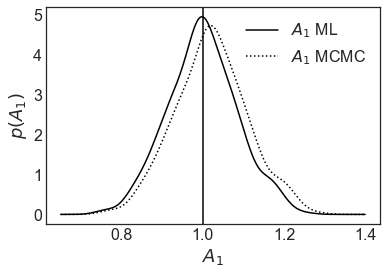

In [11]:
plt.figure(facecolor="white")
xs = np.linspace(0.65,1.4,200)
densityA1 = gaussian_kde(corr1k['A1'])
densitya1 = gaussian_kde(corr1k['a1'])
plt.plot(xs,densityA1(xs),"k-",label=r"$A_{1}$ ML")
plt.plot(xs,densitya1(xs),"k:",label=r"$A_{1}$ MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A_1$")
plt.ylabel(r"$p(A_{1})$")
plt.savefig("A1kde09.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

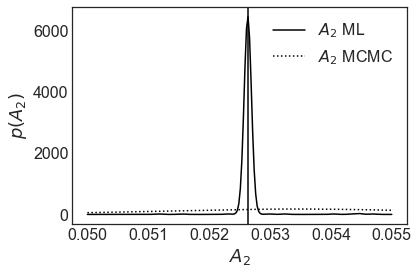

In [27]:
plt.figure(facecolor="white")
xs = np.linspace(0.05,0.055,200)
densityA2 = gaussian_kde(corr1k['A2'])
densitya2 = gaussian_kde(corr1k['a2'])
plt.plot(xs,densityA2(xs),"k-",label=r"$A_{2}$ ML")
plt.plot(xs,densitya2(xs),"k:",label=r"$A_{2}$ MCMC")
plt.axvline(x=1.0/19.0,color="k")
plt.legend()
plt.xlabel(r"$A_2$")
plt.ylabel(r"$p(A_{2})$")
plt.savefig("A2kde09.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
# display statistics
print(corr1k['dA1dA2'].mean(),corr1k['dA1dA2'].std(),corr1k['dA1dD'].mean(),corr1k['dA2dD'].mean())
print(corr1k['da1da2'].mean(),corr1k['dA1dA2'].std(),corr1k['da1dd'].mean(),corr1k['dasdd'].mean())

3.960684948967776e-08 4.0364076342799934e-07 0.0017401755063324936 4.321638639038179e-08
-2.1575118476968644e-08 4.0364076342799934e-07 0.0001589819563048703 3.9003322891733846e-08


(array([ 3.,  0.,  0.,  3.,  8., 15., 11., 18., 20., 30., 26., 32., 41.,
        40., 37., 41., 44., 26., 22., 21.,  7., 16.,  7., 10.,  9.,  2.,
         5.,  4.,  1.,  1.]),
 array([0.0559281 , 0.05819087, 0.06045364, 0.0627164 , 0.06497917,
        0.06724194, 0.06950471, 0.07176747, 0.07403024, 0.07629301,
        0.07855577, 0.08081854, 0.08308131, 0.08534408, 0.08760684,
        0.08986961, 0.09213238, 0.09439514, 0.09665791, 0.09892068,
        0.10118344, 0.10344621, 0.10570898, 0.10797175, 0.11023451,
        0.11249728, 0.11476005, 0.11702281, 0.11928558, 0.12154835,
        0.12381112]),
 <a list of 30 Patch objects>)

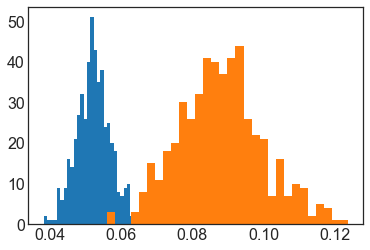

In [14]:
plt.hist(corr1k['dA1'],bins=30)
plt.hist(corr1k['da1'],bins=30)

(array([ 3.,  2.,  6.,  7., 12., 10., 15., 20., 24., 28., 26., 43., 38.,
        35., 36., 30., 32., 28., 30., 17., 10.,  9., 11., 10.,  7.,  4.,
         4.,  2.,  0.,  1.]),
 array([0.00213196, 0.00215174, 0.00217153, 0.00219131, 0.0022111 ,
        0.00223088, 0.00225067, 0.00227045, 0.00229024, 0.00231002,
        0.00232981, 0.0023496 , 0.00236938, 0.00238917, 0.00240895,
        0.00242874, 0.00244852, 0.00246831, 0.00248809, 0.00250788,
        0.00252766, 0.00254745, 0.00256724, 0.00258702, 0.00260681,
        0.00262659, 0.00264638, 0.00266616, 0.00268595, 0.00270573,
        0.00272552]),
 <a list of 30 Patch objects>)

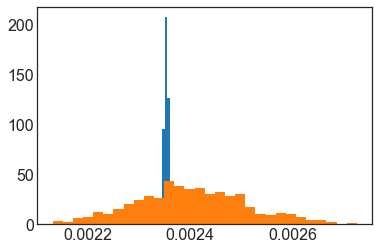

In [15]:
plt.hist(corr1k['dA2'],bins=30)
plt.hist(corr1k['da2'],bins=30)

In [16]:
print(corr1k['A1'].std()/corr1k['dA1'].mean())
print(corr1k['A2'].std()/corr1k['dA2'].mean())
print(corr1k['D'].std()/corr1k['dD'].mean())
print(corr1k['dA1dA2'].mean()/corr1k['da1da2'].mean())
print(corr1k['dA1dD'].mean()/corr1k['da1dd'].mean())
print(corr1k['dA2dD'].mean()/corr1k['dasdd'].mean())

1.6298979306264383
0.08481391303074307
1.1083494524108775
-1.835765098205969
10.94574218847491
1.10801806580282


(array([ 1.,  1.,  2.,  3.,  6.,  6., 11., 21., 15., 29., 33., 48., 45.,
        46., 39., 29., 43., 28., 27., 24., 11., 12.,  6.,  8.,  1.,  1.,
         1.,  1.,  0.,  2.]),
 array([-1.37573191e-05, -1.27661120e-05, -1.17749049e-05, -1.07836979e-05,
        -9.79249081e-06, -8.80128374e-06, -7.81007667e-06, -6.81886960e-06,
        -5.82766253e-06, -4.83645547e-06, -3.84524840e-06, -2.85404133e-06,
        -1.86283426e-06, -8.71627190e-07,  1.19579879e-07,  1.11078695e-06,
         2.10199402e-06,  3.09320109e-06,  4.08440815e-06,  5.07561522e-06,
         6.06682229e-06,  7.05802936e-06,  8.04923643e-06,  9.04044350e-06,
         1.00316506e-05,  1.10228576e-05,  1.20140647e-05,  1.30052718e-05,
         1.39964788e-05,  1.49876859e-05,  1.59788930e-05]),
 <a list of 30 Patch objects>)

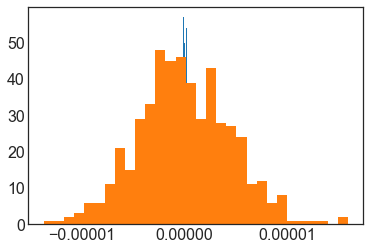

In [17]:
plt.hist(corr1k['dA1dA2'],bins=30)
plt.hist(corr1k['da1da2'],bins=30)

(array([ 1.,  0.,  0.,  0.,  2.,  2.,  2.,  6.,  8., 13., 21., 16., 28.,
        23., 37., 40., 39., 47., 39., 33., 39., 31., 16., 26., 14.,  6.,
         6.,  1.,  3.,  1.]),
 array([-1.87748453e-04, -1.67466656e-04, -1.47184858e-04, -1.26903061e-04,
        -1.06621264e-04, -8.63394671e-05, -6.60576700e-05, -4.57758729e-05,
        -2.54940759e-05, -5.21227876e-06,  1.50695183e-05,  3.53513154e-05,
         5.56331125e-05,  7.59149096e-05,  9.61967067e-05,  1.16478504e-04,
         1.36760301e-04,  1.57042098e-04,  1.77323895e-04,  1.97605692e-04,
         2.17887489e-04,  2.38169286e-04,  2.58451083e-04,  2.78732881e-04,
         2.99014678e-04,  3.19296475e-04,  3.39578272e-04,  3.59860069e-04,
         3.80141866e-04,  4.00423663e-04,  4.20705460e-04]),
 <a list of 30 Patch objects>)

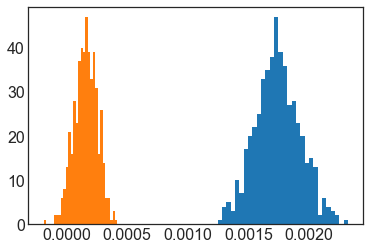

In [18]:
plt.hist(corr1k['dA1dD'],bins=30)
plt.hist(corr1k['da1dd'],bins=30)

(array([ 1.,  0.,  1.,  2.,  0.,  1.,  5., 10., 10., 15., 20., 21., 26.,
        29., 33., 40., 38., 48., 36., 35., 40., 24., 19., 16., 10.,  7.,
         8.,  1.,  2.,  2.]),
 array([-9.52226534e-06, -8.95015024e-06, -8.37803514e-06, -7.80592004e-06,
        -7.23380493e-06, -6.66168983e-06, -6.08957473e-06, -5.51745963e-06,
        -4.94534453e-06, -4.37322943e-06, -3.80111433e-06, -3.22899923e-06,
        -2.65688413e-06, -2.08476902e-06, -1.51265392e-06, -9.40538823e-07,
        -3.68423722e-07,  2.03691379e-07,  7.75806480e-07,  1.34792158e-06,
         1.92003668e-06,  2.49215178e-06,  3.06426688e-06,  3.63638199e-06,
         4.20849709e-06,  4.78061219e-06,  5.35272729e-06,  5.92484239e-06,
         6.49695749e-06,  7.06907259e-06,  7.64118769e-06]),
 <a list of 30 Patch objects>)

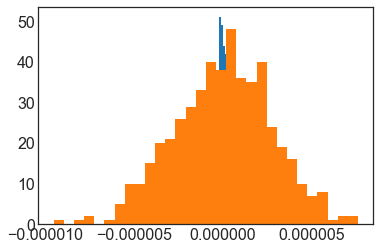

In [19]:
plt.hist(corr1k['dA2dD'],bins=30)
plt.hist(corr1k['dasdd'],bins=30)

[0.39572947 0.01732123]
factor of underestimation:  2.5269788670407043


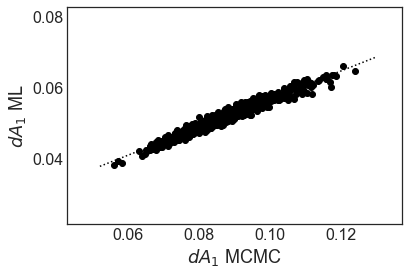

In [20]:
p1 = np.polyfit(corr1k['da1'],corr1k['dA1'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da1 = np.linspace(0.052,0.13,200)
dA1 = p1[0]*da1 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da1'],corr1k['dA1'],color="k")
plt.plot(da1,dA1,"k:")
plt.xlabel(r"$dA_1$ MCMC")
plt.ylabel(r"$dA_{1}$ ML")
plt.savefig("dA1corrkde09.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

[0.01374599 0.00232117]
factor of underestimation:  72.7484899331954


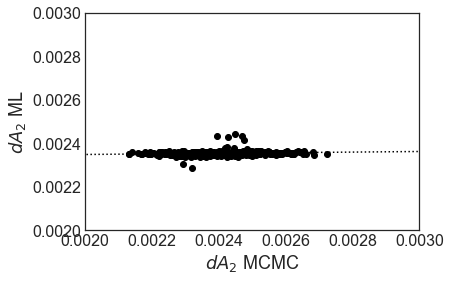

In [35]:
p1 = np.polyfit(corr1k['da2'],corr1k['dA2'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da2 = np.linspace(0.00,0.005,200)
dA2 = p1[0]*da2 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da2'],corr1k['dA2'],color="k")
plt.plot(da2,dA2,"k:")
plt.xlabel(r"$dA_2$ MCMC")
plt.ylabel(r"$dA_{2}$ ML")
plt.xlim((0.002,0.003))
plt.ylim((0.002,0.003))
plt.savefig("dA2corrkde09.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [22]:
corr1k['dA2'].min()

0.0022886274371969172